# RO 07
Franziska Boenisch / Christoph Brockmann
## Task 2/3:

In [1]:
#!/usr/bin/env python
# coding: utf-8
# imports

import sys
import math
import roslib
import rospy
import cv2
import numpy as np

from std_msgs.msg import String
from sensor_msgs.msg import Image
from sensor_msgs.msg import CompressedImage

from nav_msgs.msg import Odometry
from geometry_msgs.msg import Point, Pose, Quaternion, Twist, Vector3

from cv_bridge import CvBridge, CvBridgeError
from matplotlib import pyplot as plt

In [2]:
%matplotlib nbagg

### Plotter-Class for live-Updates:

In [3]:
# from Mustererkennung 

class Plotter(object):
    
    def __init__(self, xlabel='X', ylabel='Y', jup=False):
        self.active = False
        self.fig = None
        self.ax = None
        self.xlabel = xlabel
        self.ylabel = ylabel
        # run in a Jupyter notebook ?
        self.jup = jup
    
    def plot(self, data):
        # assume data comes in [x0, y0, x1, y1, ... xn, yn] collums per row
        r, c = data.shape
        num_sets = c//2
        colors = ['green', 'red', 'blue', 'cyan']
        
        if not self.active:
            # setup a new plot
            self.fig, self.ax = plt.subplots(1,1)
            self.ax.set_xlabel(self.xlabel, fontsize=12)
            self.ax.set_ylabel(self.ylabel, fontsize=12)
            
            for s in range(num_sets):
                x = s*2
                y = x+1
                self.ax.plot(data[:,x], data[:,y], color=colors[s], alpha=1.0)

            plt.show(block = False)
            self.active = True

        else:
            # add new data to the existing plot
            for s in range(num_sets):
                x = s*2
                y = x+1
                line = self.ax.lines[s]
                line.set_xdata(data[:,x])
                line.set_ydata(data[:,y])
                
        self.fig.canvas.draw()
        
        # if drawing in an external window
        if not self.jup:
            self.fig.canvas.flush_events()
        
        # reset axis to accomodate new data
        self.ax.relim()
        self.ax.autoscale_view()

    def save(self, filename):
        self.fig.savefig(filename)   

In [4]:
# functions
def angle(pos, pos1, pos2):
    # relative angle of two vectors
    v1 = (pos1 - pos)/np.linalg.norm(pos1 - pos)
    v2 = (pos2 - pos)/np.linalg.norm(pos2 - pos)
    
    return np.arccos(v1.dot(v2.T))

def rot_angle(pos, pos1):
    # rotation angle to x axis from [0, 2pi]
    v = pos1 - pos
    a = np.arctan2(v[1], v[0])
    if a > 0:
        return a
    else:
        return (2 * np.pi) + a


def ori(p1, p2, p3):
    return (p2[0]-p1[0])*(p3[1]-p1[1])-(p3[0]-p1[0])*(p2[1]-p1[1])

def getblobs(img, lower, upper, n=1):
    mask = cv2.inRange(img, lower, upper)
    
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)
    mask = cv2.erode(mask, kernel, iterations=1)
    #mask = cv2.dilate(mask, kernel, iterations=1)
    
    im2, contours, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    # get the two larges contours as lanes:
    contour_a = [None, None]
    first_size = 0
    secnd_size = 0

    for contour in contours:
        test = cv2.contourArea(contour)
        if test > first_size:
            contour_a[1] = contour_a[0]
            secnd_size = first_size
            contour_a[0] = contour
            first_size = test
        elif test > secnd_size:
            contour_a[1] = contour
            secnd_size = test
    
    p1_points = contour_a[0]
    if p1_points is None:
        p1 = None
    else:
        p1 = np.zeros((2))        
        p1[0] = np.average(p1_points[:,:,1])
        p1[1] = np.average(p1_points[:,:,0])
        
    if n == 1:
        return p1, mask
    else:
        p2_points = contour_a[1]
        if p2_points is None:
            p2 = None
        else:
            p2 = np.zeros((2))
            p2[0] = np.average(p2_points[:,:,1])
            p2[1] = np.average(p2_points[:,:,0])
        return p1, p2, mask

def yaw_to_quaternion(yaw):
    """ ​ ​ convert ​ ​ a ​ ​ yaw ​ ​ angle ​ ​ (in ​ ​ radians) ​ ​ into ​ ​ a ​ ​ Quaternion ​ ​ message ​ ​ """
    return Quaternion(0, 0, math.sin(yaw / 2), math.cos(yaw / 2))

## The Node

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:139: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


<IPython.core.display.Javascript object>


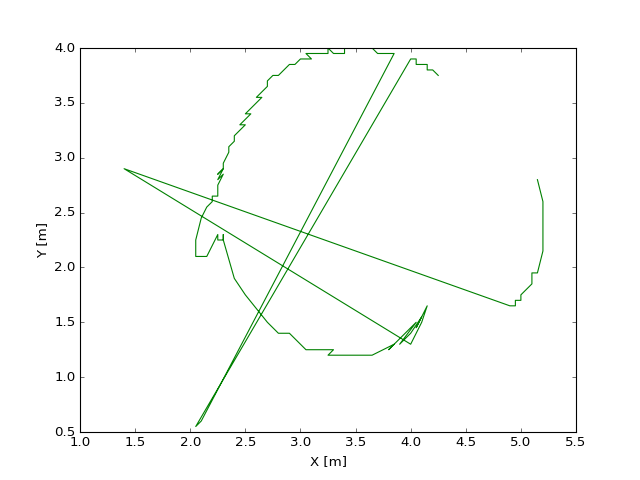

red:    [ 257.08928571  332.66071429]
green:  [  24.89473684  445.55263158]
blue:   [ 256.93333333  485.24444444]
purple: [  83.16455696  332.94936709]
pos:    [ 3.65  4.  ]
yaw:    -3.00613310058


<IPython.core.display.Javascript object>


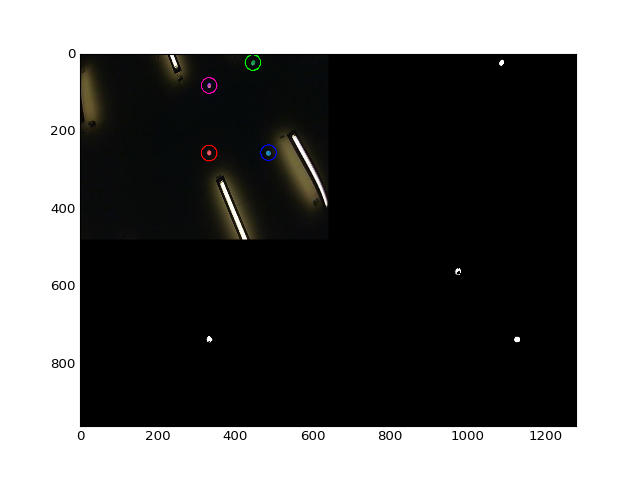

In [5]:
#!/usr/bin/env python
# coding: utf-8

# class structure analog to https://github.com/richrdcm/catkin_ws_user/tree/master/src/py_image_processing

class navigator:

    def __init__(self):
        # subscriptions
        self.image_pub_con = rospy.Publisher("/image_processing/con_fit", Image, queue_size=1)

        self.bridge = CvBridge()
        self.image_pub_bulbs = rospy.Publisher("/image_processing/con_bulbs", Image, queue_size=1)
        self.odom_pub = rospy.Publisher("odom_gps", Odometry, queue_size=50)
        
        self.compressed = True
        if self.compressed: 
            self.image_sub = rospy.Subscriber("/usb_cam/image_rect_color/compressed", CompressedImage, self.callback, queue_size=1)
        else:
            self.image_sub = rospy.Subscriber("/usb_cam/image_rect_color", Image, self.callback, queue_size=1)

        
        self.plotter = Plotter(xlabel='X [m]', ylabel='Y [m]', jup=True)
        self.data = []
        
        # setup the angle map
        """
        # old setup
        pos_r = np.array([3.57, 3.00]) 
        pos_g = np.array([2.33, 1.15])
        pos_b = np.array([3.57, 1.15])
        pos_p = np.array([2.33, 3.00])
        """
        
        # new setup
        pos_r = np.array([3.55, 3.03]) 
        pos_g = np.array([2.29, 1.14])
        pos_b = np.array([4.18, 1.77])
        pos_p = np.array([2.29, 2.40])
        
        # to correct one angle to 0
        self.angle_corr = rot_angle(pos_r, pos_g)
        
        # setup a map of precalculated angles at 5cm intervalls
        self.g_scale = 7
        self.g_off = 0  # world (0,0) is at grid (g_off/g_inc, g_off/g_inc)
        self.g_inc = 0.05
        self.g_size = int(self.g_scale / self.g_inc)
        
        self.map = np.zeros((self.g_size, self.g_size, 6))
        #self.map = np.zeros((self.g_size, self.g_size, 4))
        
        self.count = 0
        
        for x in range(self.g_size):
            for y in range(self.g_size):
                pos = np.array([x*self.g_inc-self.g_off, y*self.g_inc-self.g_off])
                # set angles
                self.map[x,y,0] = angle(pos, pos_r, pos_g)
                self.map[x,y,1] = angle(pos, pos_r, pos_b)
                self.map[x,y,2] = angle(pos, pos_g, pos_b)                
                self.map[x,y,3] = angle(pos, pos_b, pos_p)
                
                self.map[x,y,4] = angle(pos, pos_r, pos_p)
                self.map[x,y,5] = angle(pos, pos_g, pos_p)
            
    def localize(self, ang_v):
        # get map of distances
        p_map = np.linalg.norm((self.map.copy() - ang_v), axis=2)
        
        # we could get all sophisticated on that 2D array
        # but we don't
        pos = np.array(np.unravel_index(np.argmin(p_map), (self.g_size, self.g_size))) * self.g_inc 
        pos -= self.g_off
        return pos
        
                                            
    def callback(self, data):
        
        # get the image -------------------------------------------------------
        try:
            if self.compressed:
                cv_image = self.bridge.compressed_imgmsg_to_cv2(data, "bgr8")
            else:
                cv_image = self.bridge.imgmsg_to_cv2(data, "bgr8")
        except CvBridgeError as e:
            print(e)

        y_dim = cv_image.shape[0]
        x_dim = cv_image.shape[1]    

        #----------------------------------------------------------------------
        # Task 2: Colorspaces -------------------------------------------------
        #----------------------------------------------------------------------
        
        # Convert BGR to HSV
        hsv = cv2.cvtColor(cv_image, cv2.COLOR_BGR2HSV)
        
        r = 190; r_s = 20
        #r = 128; r_s = 127
        b = 130; b_s = 40
        g = 60;  g_s = 20
        
        s_low = 150; s_high = 255
        v_low = 30; v_high = 255        # the image says ca 200
        
        lower_r = np.array([r-r_s,s_low,v_low])
        upper_r = np.array([r+r_s,s_high,v_high])
        
        lower_b = np.array([b-b_s,s_low,v_low])
        upper_b = np.array([b+b_s,s_high,v_high])
        
        lower_g = np.array([g-g_s,s_low,v_low])
        upper_g = np.array([g+g_s,s_high,v_high])

        """
        IDEE: 
        benutze Masken für rot grün und blau/purple
        fitte 1, 1 und 2 Punkte (größte)
        benutze ori(p1,p2,p3) um blau und purple zu unterscheiden
        benutze interne Distanzen (oder ori) um Sinnhaftigkeit der Punkte zu beurteilen
        """
        
        control = np.zeros((y_dim*2, x_dim*2, 3), dtype=np.uint8)
        control[0:y_dim,0:x_dim,:] = cv_image
        
        # fit by color        
        pos_g, mask_g = getblobs(hsv, lower_g, upper_g, n=1)
        pos_r, mask_r = getblobs(hsv, lower_r, upper_r, n=1)       
        pos_b1, pos_b2, mask_b = pos_c = getblobs(hsv, lower_b, upper_b, n=2)
                
        # assemble the control image
        for i in range(3):
            control[0:y_dim,x_dim:,i] = mask_g
            control[y_dim:,0:x_dim,i] = mask_r
            control[y_dim:,x_dim:,i] = mask_b
        
        # test if I have data for all bulbs
        if not None in (pos_g, pos_r, pos_b1, pos_b2):
            
            # assign blue and purple by orientation test
            if ori(pos_g, pos_r, pos_b1) > 0:
                pos_b = pos_b1
                pos_p = pos_b2
            else:
                pos_b = pos_b2
                pos_p = pos_b1
            
            # plot into control
            cv2.circle(control,(int(pos_r[1]),int(pos_r[0])), 20, (0,0,255), 2)
            cv2.circle(control,(int(pos_g[1]),int(pos_g[0])), 20, (0,255,0), 2)
            cv2.circle(control,(int(pos_b[1]),int(pos_b[0])), 20, (255,0,0), 2)
            cv2.circle(control,(int(pos_p[1]),int(pos_p[0])), 20, (180,0,255), 2)
                                    
            # get distances using color positions in pixel coordinates
            d_gp = np.linalg.norm(pos_g-pos_p)
            d_gb = np.linalg.norm(pos_g-pos_b)
            d_rp = np.linalg.norm(pos_r-pos_p)
            d_rb = np.linalg.norm(pos_r-pos_b)
            
            ds = 300; dl = 300
             
            # if fitted points come in roughly the right geometry
            if (d_gp < dl and d_gb < ds and 
                d_rb < dl and d_rp < ds):
                
                self.count += 1
                
                
 
                # get angles to lights
                pos_c = np.array([x_dim//2, y_dim//2])
                
                #ang_c = np.zeros((4))
                ang_c = np.zeros((6))

                ang_c[0] = angle(pos_c, pos_r, pos_g)
                ang_c[1] = angle(pos_c, pos_r, pos_b)
                ang_c[2] = angle(pos_c, pos_g, pos_b)
                ang_c[3] = angle(pos_c, pos_b, pos_p)
                
                ang_c[4] = angle(pos_c, pos_r, pos_p)
                ang_c[5] = angle(pos_c, pos_g, pos_p)

                # convert to real world coords
                position = self.localize(ang_c)
                
                # Which direction is yaw = 0 ???
                yaw = rot_angle(pos_r, pos_g) - self.angle_corr - np.pi/2
                                
                # do something with those distances        
                self.data.append(position)
        
                # Build and publish Odometry as in:
                # https://gist.github.com/atotto/f2754f75bedb6ea56e3e0264ec405dcf
                x = position[0]
                y = position[1]

                odom = Odometry()
                odom.header.stamp = rospy.Time.now()
                odom.header.frame_id = "odom"

                # set the position
                odom.pose.pose = Pose(Point(x, y, 0.), yaw_to_quaternion(yaw))

                # set the velocity
                odom.child_frame_id = "base_link"

                # publish the message
                self.odom_pub.publish(odom)
                
                if self.count == 30:
                    print("red:    "+ str(pos_r))
                    print("green:  "+ str(pos_g))
                    print("blue:   "+ str(pos_b))
                    print("purple: "+ str(pos_p))
                    print("pos:    "+ str(position))
                    print("yaw:    "+ str(yaw))
                    
                    fig, ax = plt.subplots(1,1)
                    plt.imshow(control[:,:,[2,1,0]])
                    plt.savefig('report.png')
                
                    
        try:
            self.image_pub_bulbs.publish(self.bridge.cv2_to_imgmsg(control, "bgr8"))
        except CvBridgeError as e:
            print(e)
        
        self.plotter.plot(np.array(self.data))


# main as in https://github.com/richrdcm/catkin_ws_user/tree/master/src/py_image_processing

def main(args):
  rospy.init_node('lane_finder', anonymous=True)
  ic = navigator()
  try:
    rospy.spin()
  except KeyboardInterrupt:
    print("Shutting down")
  cv2.destroyAllWindows()


if __name__ == '__main__':
    main(sys.argv)

The most boring live-display, ever.